In [1]:
from bs4 import BeautifulSoup

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
import json

In [5]:
!pip -q install geopy

In [6]:
from geopy.geocoders import Nominatim

In [7]:
import requests
from pandas.io.json import json_normalize

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [9]:
from sklearn.cluster import KMeans

In [10]:
!pip -q install geocoder

In [11]:
import geocoder
import time

In [12]:
!pip -q install folium

In [13]:
import folium # map rendering library

In [14]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [15]:
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [16]:
rows = table.find_all('tr')
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]
df = pd.DataFrame(columns = columns)

In [18]:
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)
        df

In [19]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [20]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [21]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [22]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [23]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [24]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [25]:
df0.head(5)

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [27]:
df.shape

(533, 6)

In [28]:
df0.shape

(637, 6)

In [29]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)
df1.shape

(637, 4)

In [30]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [32]:
df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [33]:
df21.shape

(381, 4)

In [34]:
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [35]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [36]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

In [37]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [38]:
df_london.Postcode = df_london.Postcode.str.strip()
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [39]:
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [40]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [41]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [42]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [43]:
demo_london = pd.DataFrame(columns = columns1)
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [44]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [45]:
demo_london['Black'] = demo_london['Black'].astype('float')
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


In [46]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [47]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [48]:
df_se_top.shape

(46, 3)

In [49]:
df_se.shape

(80, 3)

In [50]:
def get_latlng(arcgis_geocoder):
    
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [51]:
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

In [60]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  27.350958585739136 seconds


In [61]:
df_se_loc = df_se_top
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [62]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [63]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)
df_se_loc.shape

(46, 5)

In [65]:
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [66]:
se_df.shape

(46, 5)

In [67]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


In [74]:
import json
CLIENT_ID = 'QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ' 
CLIENT_SECRET = 'CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM'
VERSION = '20180604'

In [80]:
se_df.loc[20, 'Location']

'Lewisham'

In [81]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

In [82]:
LIMIT = 100 
radius = 2000 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

In [83]:
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ&client_secret=CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM&v=20180604&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

In [84]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e83e3e677af03001bd8234b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lewisham Central',
  'headerFullLocation': 'Lewisham Central, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 182,
  'suggestedBounds': {'ne': {'lat': 51.47996001800005,
    'lng': 0.021296961190459426},
   'sw': {'lat': 51.44395998200002, 'lng': -0.03637696119035749}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535823bc498ec8d8da9aad5f',
       'name': 'Street Feast Model Market',
       'location': {'address': '196 Lewisham High St',
        'crossStreet': 'entrance at Molesworth St',
        'lat': 51.46020945743763,
        'lng': -0.01

In [86]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [87]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) 

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [88]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [89]:
nearby_venues_lewisham_unique.head(5)

,Count
Pub,13
Café,8
Gastropub,6
Park,5
Garden,4


In [90]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [91]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [92]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [93]:
se_venues.shape

(4230, 7)

In [94]:
len(se_venues)

4230

In [95]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [96]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
2,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
3,Crofton Park,51.46268,-0.03558,Waterintobeer,51.463712,-0.038826,Beer Store
4,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant


In [97]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')

In [98]:
se_venue_unique_count.head(5)

,Count
Pub,429
Coffee Shop,300
Café,270
Park,203
Grocery Store,153


In [99]:
se_venue_unique_count.describe()

,Count
count,193.000000
mean,21.917098
std,48.008825
min,1.000000
25%,4.000000
50%,8.000000
75%,19.000000
max,429.000000


In [100]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [101]:
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [102]:
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [103]:
type(se_df)

pandas.core.frame.DataFrame

In [104]:
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [105]:
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [106]:
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [107]:
se_onehot.loc[se_onehot['African Restaurant'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
137,Denmark Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
642,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
722,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1017,Gipsy Hil

In [108]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1880,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1881,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1883,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0

In [109]:
se_onehot.to_csv('selondon_onehot.csv', index = False)

In [110]:
se_onehot.shape

(4230, 194)

In [111]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.000000,0.0,0.0,0.010000,0.01,0.03,0.0,0.02,0.0,0.0,0.0,0.020000,0.020000,0.01,0.00,0.0,0.01,0.01,0.01,0.01,0.0,0.000000,0.01,0.02,0.000000,0.010000,0.0,0.00,0.01,0.000000,0.0,0.000000,0.030000,0.070000,0.0,0.00,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.010000,0.000000,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.010000,0.0,0.01,0.000000,0.00,0.020000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.020000,0.010000,0.030000,0.0,0.0,0.000000,0.000000,0.000000,0.01,0.0,0.050000,0.01,0.0,0.01,0.000000,0.0,0.0,0.000000,0.000000,0.050000,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.02,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.020000,0.050000,0.0,0.00,0.00,0.000000,0.020000,0.0,0.000000,0.0,0.000000,0.02,0.0,0.03,0.01,0.000000,0.000000,0.01,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.01,0.0,0.02,0.000000,0.0,0.0,0.03,0.000000,0.040000,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0.01,0.01,0.000000,0.0,0.020000,0.0,0.00,0.00,0.000000
1,Bellingham,0.00,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.0,

In [112]:
se_grouped.to_csv('london_grouped.csv', index = False)

In [114]:
num_top_venues = 10 

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                  venue  freq
0           Coffee Shop  0.07
1                   Pub  0.05
2                 Hotel  0.05
3    Italian Restaurant  0.05
4               Theater  0.04
5      Tapas Restaurant  0.03
6            Art Museum  0.03
7          Cocktail Bar  0.03
8    Seafood Restaurant  0.03
9  Gym / Fitness Center  0.03


----Bellingham----
                  venue  freq
0         Grocery Store  0.14
1           Supermarket  0.10
2                  Park  0.08
3           Coffee Shop  0.06
4                  Café  0.04
5    Italian Restaurant  0.04
6  Fast Food Restaurant  0.04
7                   Pub  0.04
8         Train Station  0.03
9           Gas Station  0.03


----Bermondsey----
                  venue  freq
0           Coffee Shop  0.07
1                   Pub  0.05
2                 Hotel  0.05
3    Italian Restaurant  0.05
4               Theater  0.04
5      Tapas Restaurant  0.03
6            Art Museum  0.03
7          Cocktail Bar  0.03
8    Seafoo

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [116]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [117]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

In [118]:
kclusters = 5
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)
kmeans.labels_[0:10]

array([0, 3, 0, 1, 4, 1, 4, 3, 2, 1], dtype=int32)

In [120]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [121]:
se_merged = se_df

In [122]:
se_merged.head(3)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467


In [123]:
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [124]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,1,Coffee Shop,Pub,Café,Park,Gastropub,Bar,Italian Restaurant,Cocktail Bar,Indian Restaurant,Brewery
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313,4,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Indian Restaurant,Pizza Place,Grocery Store
2,Deptford,Lewisham,SE8,51.48114,-0.02467,1,Pub,Café,Coffee Shop,Bar,Park,History Museum,Cocktail Bar,Hotel,Sandwich Place,Historic Site
3,Dulwich,Southwark,SE21,51.44100,-0.08897,1,Pub,Café,Grocery Store,Bakery,Park,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Farmers Market,Pizza Place
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,4,Pub,Café,Pizza Place,Coffee Shop,Park,Italian Restaurant,Gastropub,Garden Center,Gym / Fitness Center,Burger Joint


In [125]:
se_clusters = se_merged_latlong

In [126]:
%matplotlib inline
import matplotlib
import numpy as np

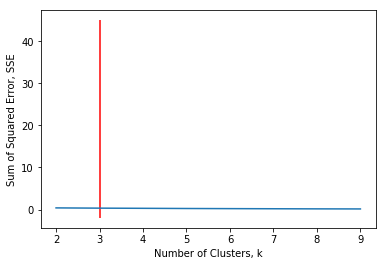

In [127]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

In [128]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6258430291046144
Where n_clusters = 3, the Silhouette Coefficient is 0.6309480172083758
Where n_clusters = 4, the Silhouette Coefficient is 0.6686434494961173
Where n_clusters = 5, the Silhouette Coefficient is 0.691510266555051
Where n_clusters = 6, the Silhouette Coefficient is 0.7244042328985575
Where n_clusters = 7, the Silhouette Coefficient is 0.7895413740822014
Where n_clusters = 8, the Silhouette Coefficient is 0.8642964068786727
Where n_clusters = 9, the Silhouette Coefficient is 0.9314576571097213


In [129]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [130]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [131]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,0,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Gym / Fitness Center,Pizza Place,Garden
6,Southwark,0,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Gym / Fitness Center,Pizza Place,Garden
7,Southwark,0,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Gym / Fitness Center,Pizza Place,Garden
8,Southwark,0,Coffee Shop,Italian Restaurant,Hotel,Pub,Theater,Cocktail Bar,Art Museum,Gym / Fitness Center,Tapas Restaurant,Seafood Restaurant
18,Lambeth,0,Coffee Shop,Italian Restaurant,Hotel,Pub,Theater,Cocktail Bar,Art Museum,Gym / Fitness Center,Tapas Restaurant,Seafood Restaurant
22,Southwark,0,Pub,Coffee Shop,Italian Restaurant,Café,Hotel,Theater,Cocktail Bar,Pizza Place,Gym / Fitness Center,Art Gallery
23,Southwark,0,Pub,Coffee Shop,Italian Restaurant,Café,Hotel,Theater,Cocktail Bar,Pizza Place,Gym / Fitness Center,Art Gallery
30,Southwark,0,Coffee Shop,Italian Restaurant,Hotel,Pub,Theater,Cocktail Bar,Art Museum,Gym / Fitness Center,Tapas Restaurant,Seafood Restaurant


In [132]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,1,Coffee Shop,Pub,Café,Park,Gastropub,Bar,Italian Restaurant,Cocktail Bar,Indian Restaurant,Brewery
2,Lewisham,1,Pub,Café,Coffee Shop,Bar,Park,History Museum,Cocktail Bar,Hotel,Sandwich Place,Historic Site
3,Southwark,1,Pub,Café,Grocery Store,Bakery,Park,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Farmers Market,Pizza Place
9,Lewisham,1,Pub,Coffee Shop,Café,Grocery Store,Park,Supermarket,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pharmacy
10,Lambeth,1,Pub,Coffee Shop,Park,Grocery Store,Café,Italian Restaurant,Bakery,Pizza Place,Pharmacy,Gym / Fitness Center
11,Lambeth,1,Pub,Coffee Shop,Park,Grocery Store,Café,Italian Restaurant,Bakery,Pizza Place,Pharmacy,Gym / Fitness Center
14,Lewisham,1,Pub,Café,Gastropub,Park,Garden,Fish & Chips Shop,Coffee Shop,Restaurant,Food Truck,Bar
15,Lewisham,1,Pub,Coffee Shop,Café,Grocery Store,Park,Supermarket,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pharmacy
16,Lewisham,1,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Restaurant,Fish & Chips Shop,Italian Restaurant,Food Truck
17,Lewisham,1,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Restaurant,Fish & Chips Shop,Italian Restaurant,Food Truck


In [133]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Lewisham,2,Grocery Store,Pub,Park,Café,Italian Restaurant,Supermarket,Coffee Shop,Gym / Fitness Center,Train Station,Indian Restaurant
19,Lewisham,2,Grocery Store,Pub,Park,Café,Italian Restaurant,Supermarket,Coffee Shop,Gym / Fitness Center,Train Station,Indian Restaurant
29,Croydon,2,Pub,Grocery Store,Café,Supermarket,Coffee Shop,Park,Clothing Store,Platform,Train Station,Mediterranean Restaurant
31,Croydon,2,Pub,Grocery Store,Café,Supermarket,Coffee Shop,Park,Clothing Store,Platform,Train Station,Mediterranean Restaurant
45,Lewisham,2,Grocery Store,Pub,Park,Café,Italian Restaurant,Supermarket,Coffee Shop,Gym / Fitness Center,Train Station,Indian Restaurant


In [134]:
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Lewisham,3,Grocery Store,Supermarket,Park,Coffee Shop,Pub,Café,Italian Restaurant,Fast Food Restaurant,Train Station,Gas Station
32,Lewisham,3,Grocery Store,Supermarket,Park,Coffee Shop,Pub,Café,Italian Restaurant,Fast Food Restaurant,Train Station,Gas Station
44,Lewisham,3,Grocery Store,Supermarket,Park,Coffee Shop,Pub,Café,Italian Restaurant,Fast Food Restaurant,Train Station,Gas Station


In [135]:
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Southwark,4,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Indian Restaurant,Pizza Place,Grocery Store
4,Southwark,4,Pub,Café,Pizza Place,Coffee Shop,Park,Italian Restaurant,Gastropub,Garden Center,Gym / Fitness Center,Burger Joint
13,Lambeth,4,Coffee Shop,Pub,Café,Brewery,Market,Pizza Place,Tapas Restaurant,Cocktail Bar,Caribbean Restaurant,Restaurant
24,Southwark,4,Pub,Café,Coffee Shop,Pizza Place,Park,Bar,Gastropub,Burger Joint,Cocktail Bar,Italian Restaurant
27,Southwark,4,Pub,Café,Coffee Shop,Pizza Place,Park,Bar,Gastropub,Burger Joint,Cocktail Bar,Italian Restaurant
35,Lambeth,4,Pub,Coffee Shop,Café,Grocery Store,Park,Pizza Place,Gym / Fitness Center,Brewery,Bakery,Restaurant
36,Lambeth,4,Pub,Coffee Shop,Café,Grocery Store,Park,Pizza Place,Gym / Fitness Center,Brewery,Bakery,Restaurant
41,Lambeth,4,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Indian Restaurant,Pizza Place,Grocery Store
43,Southwark,4,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Indian Restaurant,Pizza Place,Grocery Store
